# Conditional GAN (cGAN) for MNIST Digit Generation

## Introduction to Conditional GANs

While standard GANs generate random samples, **Conditional GANs** give us control over what is generated by conditioning the generation process on additional information (e.g., class labels).

### What You'll Learn
- How to modify DCGAN architecture for conditional generation
- Training a cGAN on MNIST to generate specific digits (0-9)
- Building an inference function to generate digits on demand
- Label embedding techniques for GANs

### Key Differences from Standard DCGAN
1. **Generator**: Takes noise vector + class label → generates image of that class
2. **Discriminator**: Takes image + class label → determines if image is real/fake for that class
3. **Dataset**: MNIST (28x28 grayscale handwritten digits, 10 classes)

### Architecture Overview
- **Label Embedding**: Convert discrete labels to continuous vectors
- **Concatenation**: Merge labels with noise (Generator) or images (Discriminator)
- **Training**: Same adversarial training as DCGAN, but conditioned on labels

Let's get started! 🚀

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import os

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
nz = 100  # Latent noise vector size
num_classes = 10  # MNIST has 10 digit classes (0-9)
embed_dim = 100  # Embedding dimension for class labels
ngf = 64  # Generator feature map size
ndf = 64  # Discriminator feature map size
num_epochs = 50  # Training epochs
lr = 0.0002  # Learning rate
beta1 = 0.5  # Adam beta1
batch_size = 128
image_size = 28  # MNIST native size
nc = 1  # Grayscale (1 channel)

# Create output directory
os.makedirs("outputs_cgan", exist_ok=True)

print("Setup complete!")
print(f"Configuration: Image size={image_size}x{image_size}, Channels={nc}, Classes={num_classes}")

Using device: cuda:0
Setup complete!
Configuration: Image size=28x28, Channels=1, Classes=10


## 2. Conditional Generator

The generator takes:
- **Noise vector** `z` (100-dim)
- **Class label** (integer 0-9)

Process:
1. Embed label into `embed_dim`-dimensional space
2. Concatenate embedded label with noise vector
3. Pass through transposed convolutions to generate 28x28 image

**Architecture**: Linear projection → Reshape → 3 TransposedConv layers → Tanh output

In [2]:
class ConditionalGenerator(nn.Module):
    def __init__(self, nz=100, num_classes=10, embed_dim=100, ngf=64, nc=1):
        super(ConditionalGenerator, self).__init__()
        
        # Label embedding layer: converts class index to dense vector
        self.label_emb = nn.Embedding(num_classes, embed_dim)
        
        # Generator input is noise + embedded label
        input_dim = nz + embed_dim
        
        # Architecture: Project concatenated input to feature maps, then upsample
        self.gen = nn.Sequential(
            # Project and reshape: (nz + embed_dim) -> ngf*8 * 7 * 7
            nn.Linear(input_dim, ngf * 8 * 7 * 7),
            nn.BatchNorm1d(ngf * 8 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (ngf * 8, 7, 7)),  # Reshape to (512, 7, 7)
            
            # Upsample to 14x14
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),  # 512 -> 256 x 14 x 14
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # Upsample to 28x28
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # 256 -> 128 x 28 x 28
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # Final conv to get 1 channel (grayscale)
            nn.Conv2d(ngf * 2, nc, kernel_size=3, stride=1, padding=1, bias=False),  # 128 -> 1 x 28 x 28
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, noise, labels):
        """
        Args:
            noise: (batch_size, nz) - Random noise vectors
            labels: (batch_size,) - Class labels as integers
        Returns:
            Generated images (batch_size, nc, 28, 28)
        """
        # Embed labels and concatenate with noise
        label_emb = self.label_emb(labels)  # (batch_size, embed_dim)
        gen_input = torch.cat([noise, label_emb], dim=1)  # (batch_size, nz + embed_dim)
        return self.gen(gen_input)

# Test the generator
netG = ConditionalGenerator(nz, num_classes, embed_dim, ngf, nc).to(device)
test_noise = torch.randn(4, nz, device=device)
test_labels = torch.tensor([0, 1, 2, 3], device=device)
test_output = netG(test_noise, test_labels)
print(f"Generator output shape: {test_output.shape}")
print(f"Expected: torch.Size([4, 1, 28, 28])")
print(f"Generator parameters: {sum(p.numel() for p in netG.parameters()):,}")

Generator output shape: torch.Size([4, 1, 28, 28])
Expected: torch.Size([4, 1, 28, 28])
Generator parameters: 7,717,224


## 3. Conditional Discriminator

The discriminator takes:
- **Image** (28x28 grayscale)
- **Class label** (integer 0-9)

Process:
1. Embed label into spatial map (same size as image)
2. Concatenate label channel with image
3. Pass through convolutions to classify as real/fake

**Architecture**: Strided convolutions for downsampling → Final classifier

In [3]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10, ndf=64, nc=1, image_size=28):
        super(ConditionalDiscriminator, self).__init__()
        self.image_size = image_size
        
        # Label embedding: project to spatial map
        self.label_emb = nn.Embedding(num_classes, image_size * image_size)
        
        # Discriminator takes image + label channel as input
        self.disc = nn.Sequential(
            # Input: (nc + 1) x 28 x 28 (image + label map)
            nn.Conv2d(nc + 1, ndf, 4, 2, 1, bias=False),  # (nc+1) -> 64 x 14 x 14
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 64 -> 128 x 7 x 7
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False),  # 128 -> 256 x 4 x 4
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Final classifier
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),  # 256 -> 1 x 1 x 1
            nn.Sigmoid()
        )

    def forward(self, images, labels):
        """
        Args:
            images: (batch_size, nc, 28, 28) - Input images
            labels: (batch_size,) - Class labels as integers
        Returns:
            Probability of being real (batch_size,)
        """
        # Embed labels to spatial maps
        label_emb = self.label_emb(labels)  # (batch_size, 28*28)
        label_emb = label_emb.view(-1, 1, self.image_size, self.image_size)  # (batch_size, 1, 28, 28)
        
        # Concatenate image with label map
        disc_input = torch.cat([images, label_emb], dim=1)  # (batch_size, nc+1, 28, 28)
        
        output = self.disc(disc_input)
        return output.view(-1)  # Flatten to (batch_size,)

# Test the discriminator
netD = ConditionalDiscriminator(num_classes, ndf, nc, image_size).to(device)
test_images = torch.randn(4, nc, image_size, image_size, device=device)
test_labels = torch.tensor([0, 1, 2, 3], device=device)
test_output = netD(test_images, test_labels)
print(f"Discriminator output shape: {test_output.shape}")
print(f"Expected: torch.Size([4])")
print(f"Discriminator parameters: {sum(p.numel() for p in netD.parameters()):,}")

Discriminator output shape: torch.Size([4])
Expected: torch.Size([4])
Discriminator parameters: 440,736


## 4. Load MNIST Dataset

MNIST contains 60,000 training images of handwritten digits (0-9).

100%|██████████| 9.91M/9.91M [00:01<00:00, 8.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 321kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.44MB/s]

Dataset loaded: 60000 images
Number of batches: 469


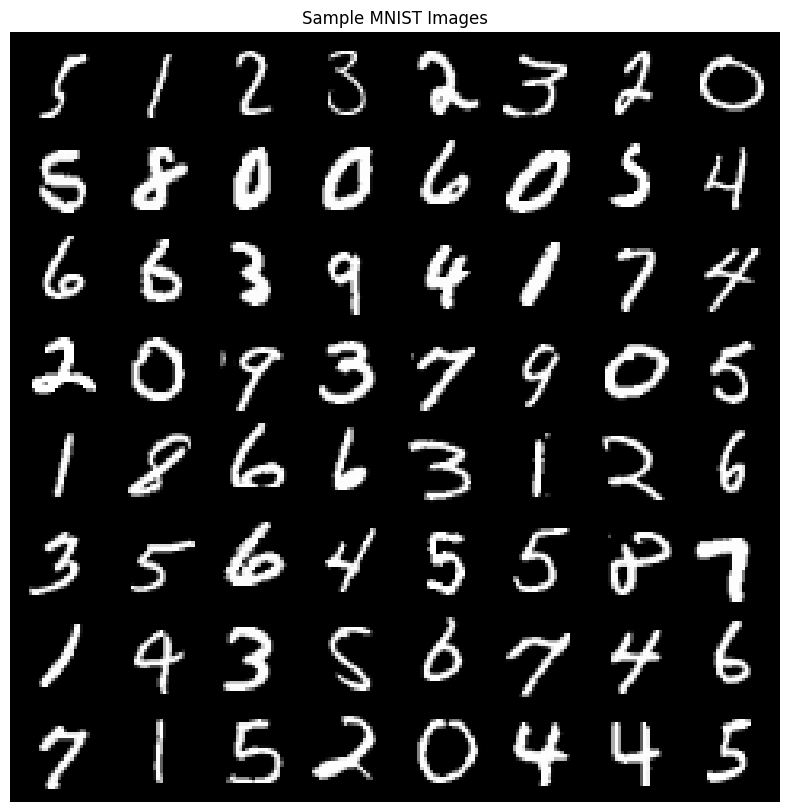

Sample labels: [5, 1, 2, 3, 2, 3, 2, 0, 5, 8, 0, 0, 6, 0, 5, 4]


In [4]:
# Data transforms: normalize to [-1, 1] to match Tanh output
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Grayscale normalization
])

# Download and load MNIST
dataset = datasets.MNIST(root="input/data", download=True, train=True, transform=transform)
dataloader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Dataset loaded: {len(dataset)} images")
print(f"Number of batches: {len(dataloader)}")

# Visualize sample images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Sample MNIST Images")
grid = vutils.make_grid(real_batch[0][:64], padding=2, normalize=True, nrow=8)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

# Print some labels
print(f"Sample labels: {real_batch[1][:16].tolist()}")

## 5. Initialize Models and Training Components

In [5]:
# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Embedding') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

# Create models
netG = ConditionalGenerator(nz, num_classes, embed_dim, ngf, nc).to(device)
netD = ConditionalDiscriminator(num_classes, ndf, nc, image_size).to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Fixed noise for visualization (generate one image per class)
fixed_noise = torch.randn(num_classes * 10, nz, device=device)  # 10 samples per class
fixed_labels = torch.tensor([i for i in range(num_classes) for _ in range(10)], device=device)

# Real and fake labels
real_label = 1.0
fake_label = 0.0

print("Models initialized and ready for training!")
print(f"Generator params: {sum(p.numel() for p in netG.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in netD.parameters()):,}")

Models initialized and ready for training!
Generator params: 7,717,224
Discriminator params: 440,736


## 6. Training Loop

Standard GAN training:
1. **Train Discriminator**: Maximize ability to distinguish real from fake
2. **Train Generator**: Maximize ability to fool discriminator

Key difference: Both networks are conditioned on labels!

In [6]:
# Training loop
img_list = []
G_losses = []
D_losses = []

print("Starting Training Loop...")
print(f"Total epochs: {num_epochs}, Batches per epoch: {len(dataloader)}")
print("-" * 80)

for epoch in range(num_epochs):
    for i, (real_images, real_labels) in enumerate(dataloader):
        batch_size_actual = real_images.size(0)
        real_images = real_images.to(device)
        real_labels = real_labels.to(device)
        
        # ==================== Train Discriminator ====================
        netD.zero_grad()
        
        # Train on real images
        label_real = torch.full((batch_size_actual,), real_label, dtype=torch.float, device=device)
        output_real = netD(real_images, real_labels)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()
        D_x = output_real.mean().item()
        
        # Train on fake images
        noise = torch.randn(batch_size_actual, nz, device=device)
        fake_labels = torch.randint(0, num_classes, (batch_size_actual,), device=device)
        fake_images = netG(noise, fake_labels)
        
        label_fake = torch.full((batch_size_actual,), fake_label, dtype=torch.float, device=device)
        output_fake = netD(fake_images.detach(), fake_labels)
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # ==================== Train Generator ====================
        netG.zero_grad()
        label_real_for_G = torch.full((batch_size_actual,), real_label, dtype=torch.float, device=device)
        output = netD(fake_images, fake_labels)
        errG = criterion(output, label_real_for_G)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Save losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Print statistics
        if i % 100 == 0:
            print(f'[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    
    # Generate images with fixed noise after each epoch
    with torch.no_grad():
        fake_images_fixed = netG(fixed_noise, fixed_labels).detach().cpu()
    img_list.append(vutils.make_grid(fake_images_fixed, padding=2, normalize=True, nrow=10))
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save(netG.state_dict(), f"outputs_cgan/generator_epoch_{epoch+1}.pth")
        torch.save(netD.state_dict(), f"outputs_cgan/discriminator_epoch_{epoch+1}.pth")
        print(f"Models saved at epoch {epoch+1}")

print("-" * 80)
print("Training complete!")

Starting Training Loop...
Total epochs: 50, Batches per epoch: 469
--------------------------------------------------------------------------------
[1/50][0/469] Loss_D: 1.8881 Loss_G: 1.0301 D(x): 0.2633 D(G(z)): 0.3322 / 0.3930
[1/50][100/469] Loss_D: 0.8911 Loss_G: 2.1931 D(x): 0.8102 D(G(z)): 0.4560 / 0.1317
[1/50][200/469] Loss_D: 0.5534 Loss_G: 1.2154 D(x): 0.6922 D(G(z)): 0.1494 / 0.3214
[1/50][300/469] Loss_D: 0.4562 Loss_G: 4.0466 D(x): 0.9658 D(G(z)): 0.3142 / 0.0240
[1/50][400/469] Loss_D: 0.3247 Loss_G: 2.9267 D(x): 0.9136 D(G(z)): 0.1924 / 0.0685
[2/50][0/469] Loss_D: 0.6424 Loss_G: 2.6894 D(x): 0.9474 D(G(z)): 0.3901 / 0.0965
[2/50][100/469] Loss_D: 0.6547 Loss_G: 3.1538 D(x): 0.9172 D(G(z)): 0.3890 / 0.0574
[2/50][200/469] Loss_D: 0.7976 Loss_G: 3.1458 D(x): 0.9291 D(G(z)): 0.4742 / 0.0545
[2/50][300/469] Loss_D: 0.7779 Loss_G: 2.5057 D(x): 0.9033 D(G(z)): 0.4479 / 0.1040
[2/50][400/469] Loss_D: 0.6317 Loss_G: 1.5822 D(x): 0.7268 D(G(z)): 0.2396 / 0.2385
[3/50][0/469] Lo

## 7. Visualize Training Progress

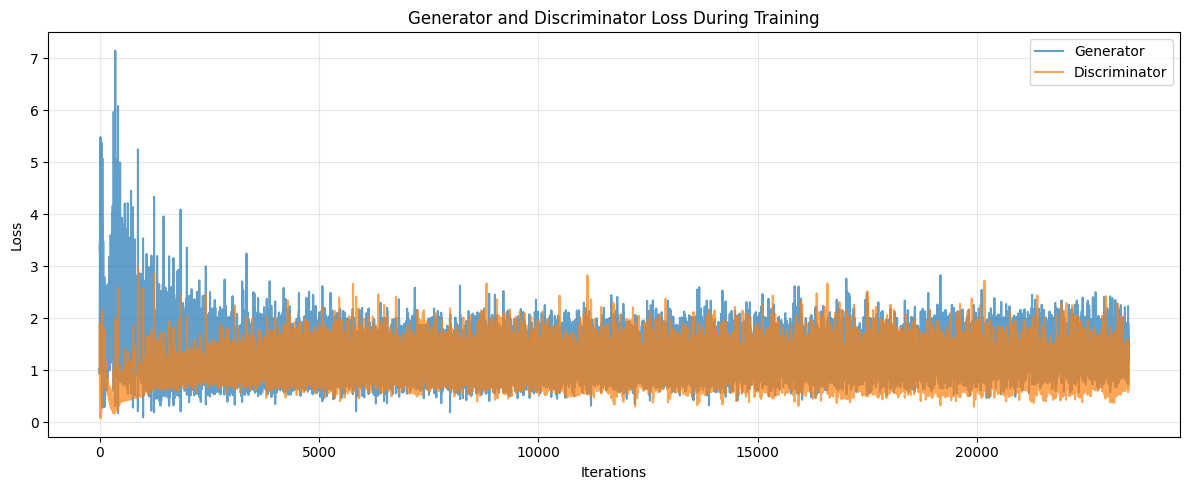

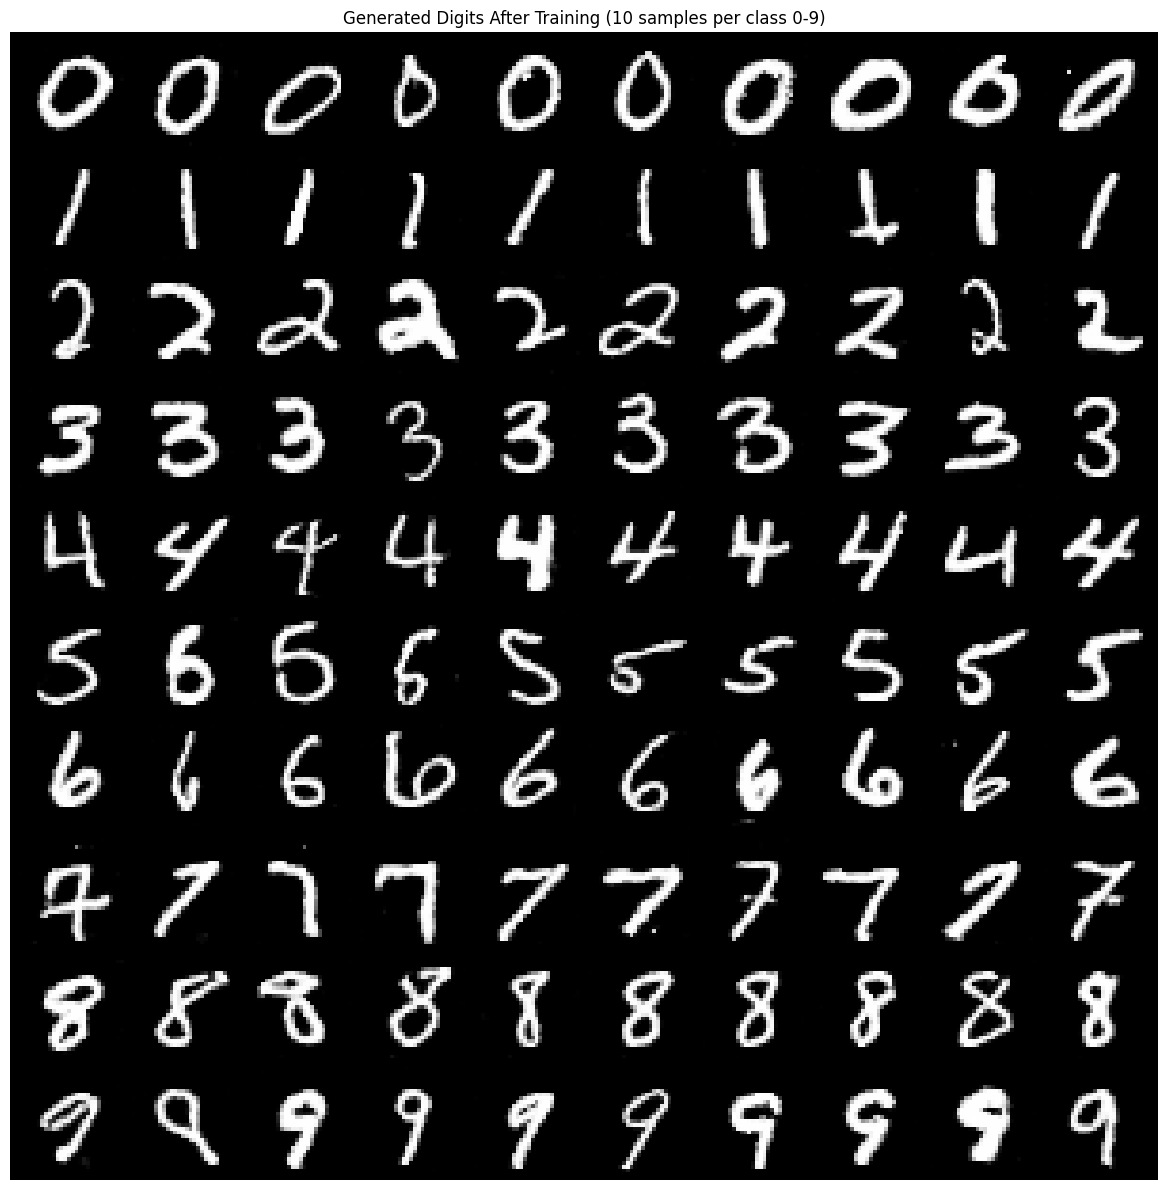

In [7]:
# Plot losses
plt.figure(figsize=(12, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator", alpha=0.7)
plt.plot(D_losses, label="Discriminator", alpha=0.7)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outputs_cgan/training_losses.png", dpi=150)
plt.show()

# Show final generated images (all classes)
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Generated Digits After Training (10 samples per class 0-9)")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.tight_layout()
plt.savefig("outputs_cgan/final_generated_images.png", dpi=150)
plt.show()

## 8. Inference Function: Generate Digits on Demand

This is the key feature! Generate specific digits by providing labels.

In [8]:
def generate_digits(generator, labels, num_samples_per_label=10, nz=100, device='cuda:0'):
    """
    Generate images of specific digits using the trained conditional GAN.
    
    Args:
        generator: Trained ConditionalGenerator model
        labels: List or tensor of digit labels to generate (e.g., [0, 1, 5, 7])
        num_samples_per_label: Number of different samples to generate for each label
        nz: Dimension of noise vector (must match training)
        device: Device to run on ('cuda:0' or 'cpu')
    
    Returns:
        generated_images: Tensor of shape (len(labels) * num_samples_per_label, 1, 28, 28)
        all_labels: Corresponding labels for each generated image
    """
    generator.eval()  # Set to evaluation mode
    
    # Convert labels to tensor if needed
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)
    
    # Create repeated labels: [0, 0, 0, ..., 1, 1, 1, ..., etc.]
    all_labels = torch.repeat_interleave(labels, num_samples_per_label).to(device)
    total_samples = len(all_labels)
    
    # Generate random noise
    noise = torch.randn(total_samples, nz, device=device)
    
    # Generate images
    with torch.no_grad():
        generated_images = generator(noise, all_labels)
    
    return generated_images, all_labels


def visualize_generated_digits(generated_images, labels, nrow=10, figsize=(15, 8)):
    """
    Visualize generated digits in a grid.
    
    Args:
        generated_images: Tensor of generated images
        labels: Corresponding labels
        nrow: Number of images per row in the grid
        figsize: Figure size for matplotlib
    """
    # Create grid
    grid = vutils.make_grid(generated_images.cpu(), padding=2, normalize=True, nrow=nrow)
    
    # Plot
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.title(f"Generated Digits (Labels: {torch.unique(labels.cpu()).tolist()})")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.tight_layout()
    plt.show()

print("Inference functions defined!")
print("\nUsage examples:")
print("  # Generate 10 examples of digit '5':")
print("  images, labels = generate_digits(netG, labels=[5], num_samples_per_label=10)")
print("  visualize_generated_digits(images, labels)")
print("\n  # Generate multiple digits:")
print("  images, labels = generate_digits(netG, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], num_samples_per_label=10)")
print("  visualize_generated_digits(images, labels, nrow=10)")

Inference functions defined!

Usage examples:
  # Generate 10 examples of digit '5':
  images, labels = generate_digits(netG, labels=[5], num_samples_per_label=10)
  visualize_generated_digits(images, labels)

  # Generate multiple digits:
  images, labels = generate_digits(netG, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], num_samples_per_label=10)
  visualize_generated_digits(images, labels, nrow=10)


## 9. Test the Inference Function

Let's generate specific digits!

Example 1: Generating 20 samples of digit '7'


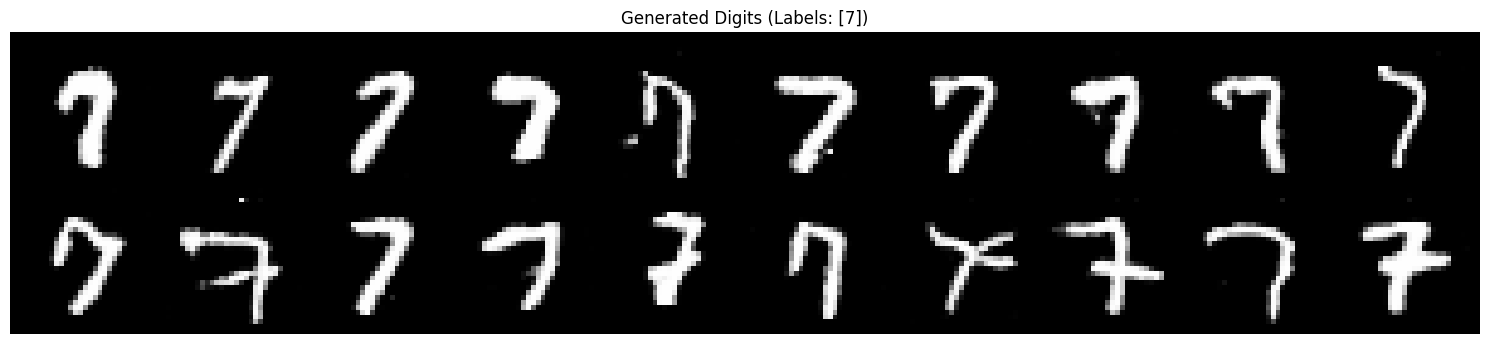

In [9]:
# Example 1: Generate 20 examples of the digit '7'
print("Example 1: Generating 20 samples of digit '7'")
images_7, labels_7 = generate_digits(netG, labels=[7], num_samples_per_label=20, nz=nz, device=device)
visualize_generated_digits(images_7, labels_7, nrow=10, figsize=(15, 4))

Example 2: Generating 10 samples each of digits 0, 3, 5, and 9


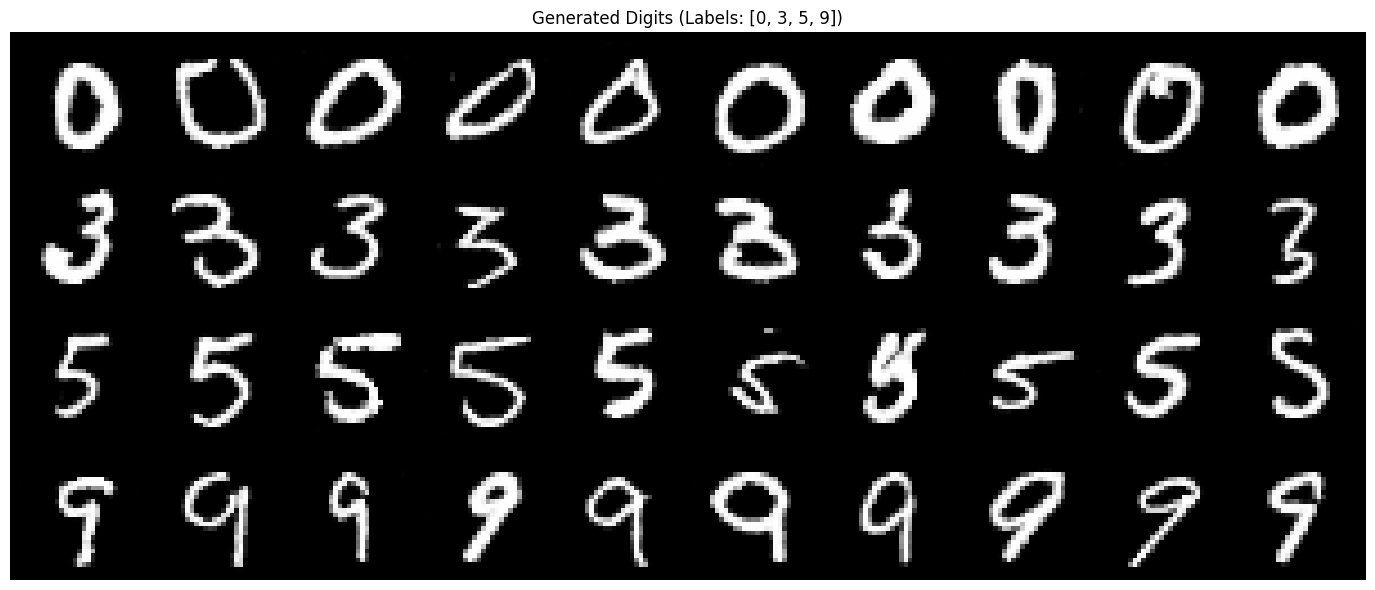

In [10]:
# Example 2: Generate 10 samples of digits 0, 3, 5, and 9
print("Example 2: Generating 10 samples each of digits 0, 3, 5, and 9")
images_mixed, labels_mixed = generate_digits(netG, labels=[0, 3, 5, 9], num_samples_per_label=10, nz=nz, device=device)
visualize_generated_digits(images_mixed, labels_mixed, nrow=10, figsize=(15, 6))

Example 3: Generating 10 samples of each digit (0-9)


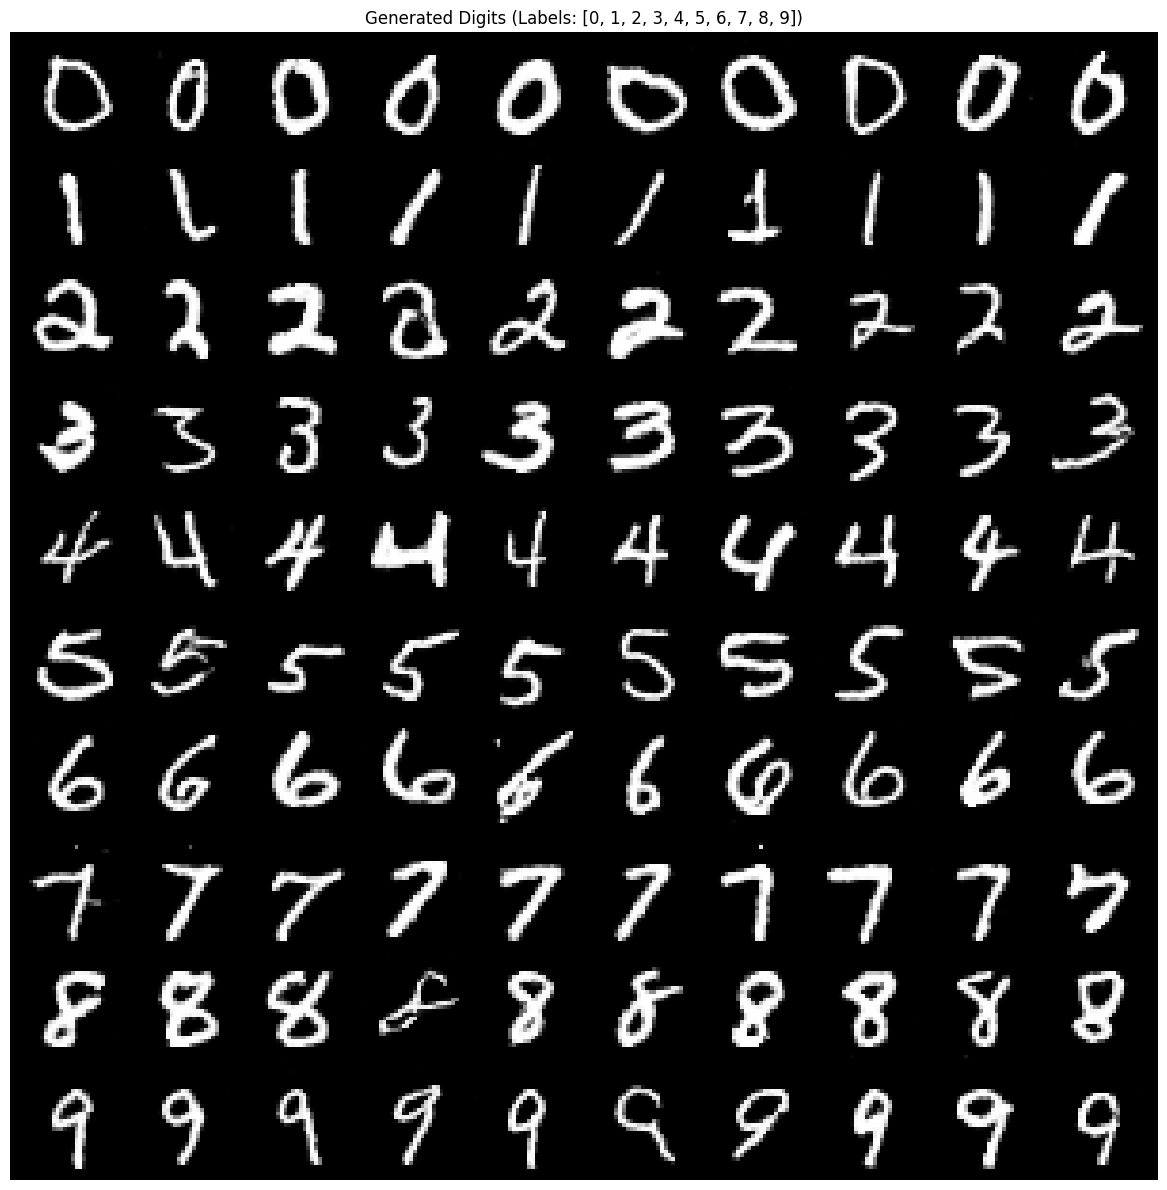

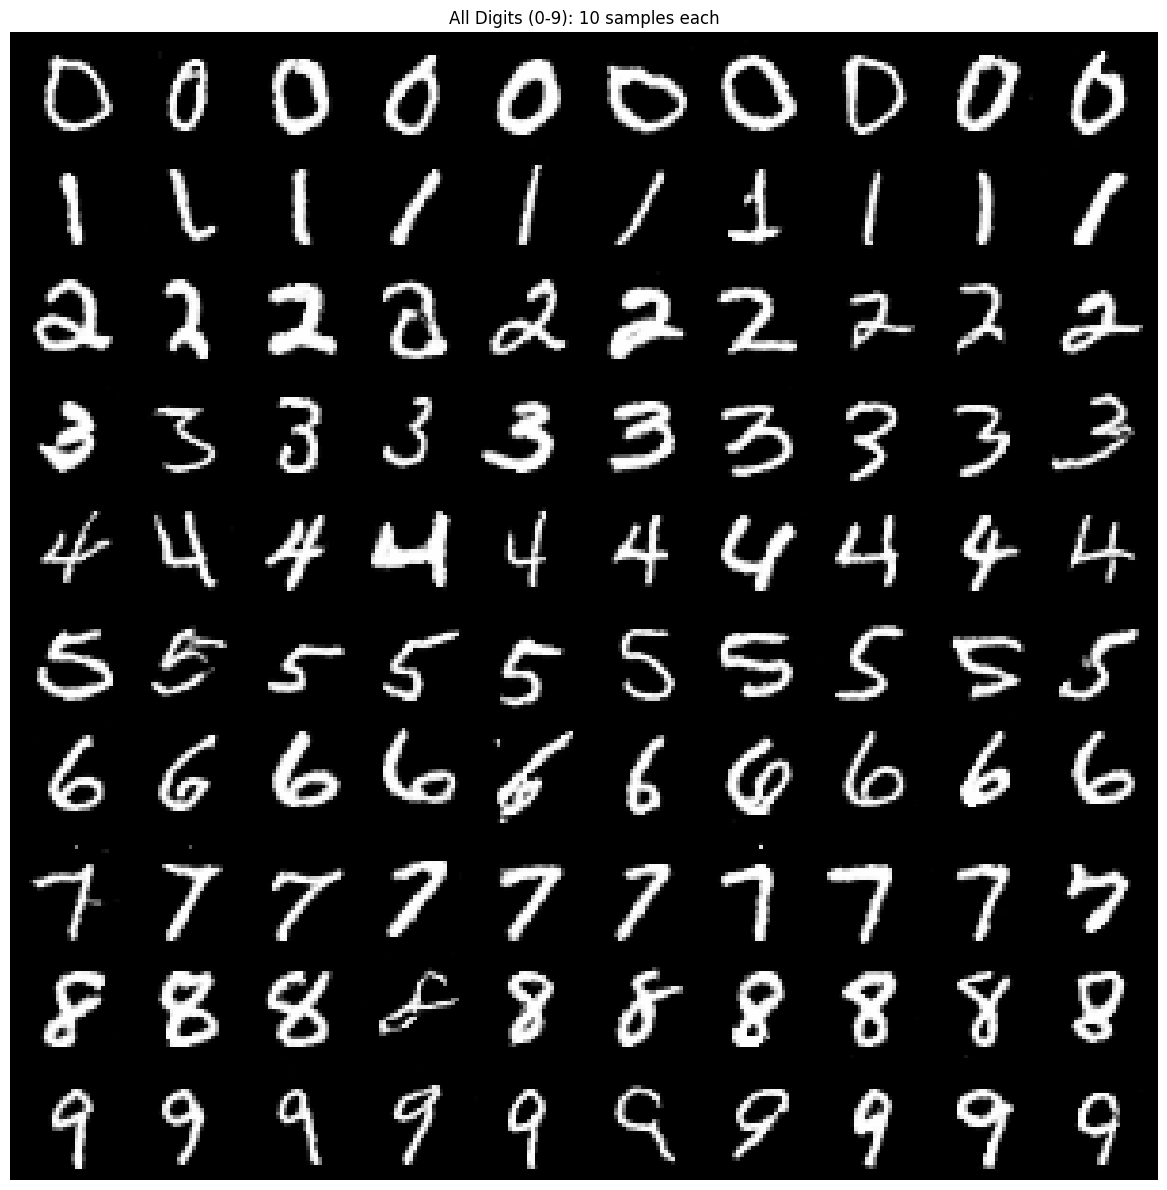

In [11]:
# Example 3: Generate all digits (0-9) with 10 samples each
print("Example 3: Generating 10 samples of each digit (0-9)")
all_digits = list(range(10))
images_all, labels_all = generate_digits(netG, labels=all_digits, num_samples_per_label=10, nz=nz, device=device)
visualize_generated_digits(images_all, labels_all, nrow=10, figsize=(15, 12))

# Save this visualization
grid = vutils.make_grid(images_all.cpu(), padding=2, normalize=True, nrow=10)
plt.figure(figsize=(15, 12))
plt.axis("off")
plt.title("All Digits (0-9): 10 samples each")
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.tight_layout()
plt.savefig("outputs_cgan/all_digits_generated.png", dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Example 4: Generate a large batch of a single digit
print("Example 4: Generating 50 samples of digit '2'")
images_2, labels_2 = generate_digits(netG, labels=[2], num_samples_per_label=50, nz=nz, device=device)
visualize_generated_digits(images_2, labels_2, nrow=10, figsize=(15, 8))

## 10. Save Individual Generated Images

Extract and save individual generated images for further use.

In [ ]:
def save_generated_images(generated_images, labels, output_dir="outputs_cgan/samples"):
    """
    Save individual generated images to disk.
    
    Args:
        generated_images: Tensor of generated images
        labels: Corresponding labels
        output_dir: Directory to save images
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for idx, (img, label) in enumerate(zip(generated_images, labels)):
        # Denormalize from [-1, 1] to [0, 1]
        img = (img + 1) / 2.0
        
        # Save using torchvision
        filename = f"{output_dir}/digit_{label.item()}_sample_{idx:04d}.png"
        vutils.save_image(img, filename)
    
    print(f"Saved {len(generated_images)} images to {output_dir}")

# Save some examples
print("Saving 10 samples of each digit...")
images_to_save, labels_to_save = generate_digits(netG, labels=list(range(10)), num_samples_per_label=10, nz=nz, device=device)
save_generated_images(images_to_save, labels_to_save)

## 11. Interactive Digit Generation

Try generating your own digits by changing the parameters!

In [ ]:
# ========== CUSTOMIZE THIS CELL ==========
# Change these parameters to generate different digits:

digit_to_generate = 8  # Choose a digit from 0-9
num_samples = 25  # How many samples to generate

# =========================================

print(f"Generating {num_samples} samples of digit '{digit_to_generate}'...")
images, labels = generate_digits(netG, labels=[digit_to_generate], num_samples_per_label=num_samples, nz=nz, device=device)
visualize_generated_digits(images, labels, nrow=5, figsize=(12, 10))

print(f"\nGenerated {len(images)} images of digit {digit_to_generate}")

## 12. Save Final Models

In [ ]:
# Save final trained models
torch.save(netG.state_dict(), "outputs_cgan/conditional_generator_final.pth")
torch.save(netD.state_dict(), "outputs_cgan/conditional_discriminator_final.pth")

print("Final models saved!")
print("\nTo load the generator later:")
print("  netG = ConditionalGenerator(nz, num_classes, embed_dim, ngf, nc).to(device)")
print("  netG.load_state_dict(torch.load('outputs_cgan/conditional_generator_final.pth'))")
print("  netG.eval()")

## 13. Summary and Next Steps

### What We Accomplished
- Built a **Conditional GAN** that can generate specific MNIST digits on demand
- Implemented label embedding for both Generator and Discriminator
- Created an **inference function** to generate digits by specifying labels
- Trained on MNIST dataset with grayscale 28x28 images

### Key Differences from DCGAN
| Aspect | DCGAN | Conditional GAN |
|--------|-------|----------------|
| Input | Random noise only | Noise + class label |
| Control | No control over output | Full control via labels |
| Architecture | Standard conv layers | Embedding layers + concat |
| Use Case | Random generation | Targeted generation |

### Exercise Ideas
1. **Latent Space Interpolation**: Generate smooth transitions between different digits
2. **Quality Assessment**: Calculate FID score to quantitatively measure generation quality
3. **Architecture Experiments**: Try different embedding dimensions or network depths
4. **Other Datasets**: Apply to Fashion-MNIST or CIFAR-10 with 10 classes
5. **Advanced Conditioning**: Use one-hot encoding instead of embeddings

### Further Reading
- Original cGAN paper: [Mirza & Osindero (2014)](https://arxiv.org/abs/1411.1784)
- AC-GAN: Auxiliary Classifier GAN for better class conditioning
- StyleGAN: State-of-the-art controllable generation

Congratulations! You've successfully implemented a Conditional GAN with inference capabilities! 🎉